# LUS-CS433

TODO general project description + do a readme

For this task, we decide to explore a supervised learning approach, using CNNs.
Our initial idea is the following: to train a binary classifier ideally able to emulate a clinician's judgement, namely telling us wether an image taken from an LUS video of a patient site should be selected or not.

TODO explain why classifier is multi site, wether we should do multiple classifiers (one per site)

### Imports

In [1]:
from encoders import CnnEncoder
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import glob
import sys

## 1. Data Exploration

TODO some data exploration (number of images, videos, formats, etc)

explain the concept of patient site
#### Image shape
We first check whether images in the dataset have allt the same shapes.

In [82]:
butterfly_img_path = glob.glob("data/Ultrason butterflynetwork/*.png")
lus_neg_img_path = glob.glob("data/ppredictus_images/LUS images/negative/*.png")
vid_img_path = glob.glob("data/Ultrason butterflynetwork/*.mp4")

def count_formats(path_list):
    counts = {}
    for path in path_list:
        key = cv2.imread(path).shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

def count_formats_vid(path_list):
    counts = {}
    for path in path_list:
        video = cv2.VideoCapture(path)
        success, img = video.read()
        
        if success == False :
            raise("Exception nulle")
        
        key = img.shape
        video.release()
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

In [83]:
butterfly_format = count_formats(butterfly_img_path)
butterfly_format

{(1080, 791, 3): 3445, (1080, 790, 3): 2}

In [84]:
lus_neg_format = count_formats(lus_neg_img_path)
lus_neg_format

{(1080, 804, 3): 1152, (1080, 791, 3): 91}

In [85]:
vid_format = count_formats_vid(vid_img_path)
vid_format

{(1080, 792, 3): 1265}

We see that it is not everywhere the case, so we can't infer that we'll always the same type of images. It seems that our videos have all the same shapes. However most of our images in the butterfly dataset come from videos.

From this analysis, we also get that we have 3447 images in the butterfly dataset, and 1265 videos. While in the LUS_neg dataset, we have 1243 images.

Let's inspect more precisely our videos:

In [3]:
one_vid_path = vid_img_path[0]
print(one_vid_path)
def count_formats_vid(vid_path):
    counts = {}
    video = cv2.VideoCapture(vid_path)
    while(video.isOpened()):
        success, img = video.read()
        
        if success == False :
            print('problem')
            continue
        key = img.shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    print("hello")
    return counts

data/Ultrason butterflynetwork\1_100_QLD.mp4


In [4]:
count_formats_vid(one_vid_path)

problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem


problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem


problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem


problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem
problem


KeyboardInterrupt: 

I couldn't run the cell, but we should have seen that even in one video, the format could sometimes change by one or 2 pixels. This explains why we have different images shape in our images dataset.

#### How is our dataset distributed according to sites?
When a clinician performs a lung ultrasound (LUS) examination, he generally acquires several images on different thoracic sites. Each lung is partitioned in four quadrants (anterior or posterior and superior or inferior). They also perform one lung ultrasound on the side of the lung which implies that a patient could have up to 10 different videos of his lungs.

Here we look how is our data distributed according to each site:

In [39]:
def get_sites(path):
    site_nb = {}
    for data_path in path:
        site_ext = data_path.split('_')[2]#get the site, but could contain extension
        site = site_ext.split(".")[0]#removes the extension
        
        if site not in site_nb.keys():
            site_nb[site] = 1
        else:
            site_nb[site] = site_nb[site] + 1
    return site_nb

In [86]:
#Some files had misspellings, we take fix this here by modifying their names:
old_path = 'data/Ultrason butterflynetwork/1_46_QAiG_1.png'
new_path = old_path.replace("QAiG", "QAIG", 1)
print(new_path)
#os.rename(old_path, new_path)

old_path2 = 'data/Ultrason butterflynetwork/1_156_QASD-1.png'
new_path2 = old_path2.replace("QASD-1", "QASD_1")
print(new_path2)
#os.rename(old_path2, new_path2)

data/Ultrason butterflynetwork/1_46_QAIG_1.png
data/Ultrason butterflynetwork/1_156_QASD_1.png


In [87]:
butterfly_site_nb = dict(sorted(get_sites(butterfly_img_path).items()))
butterfly_site_nb

{'QAID': 367,
 'QAIG': 348,
 'QASD': 397,
 'QASG': 383,
 'QASP': 1,
 'QLD': 229,
 'QLG': 225,
 'QPID': 354,
 'QPIG': 349,
 'QPSD': 397,
 'QPSG': 382,
 'UNK': 17}

We decide that UNK (don't know what it refers to) and QASP (Antérieur Supérieur Postérieur?) images are outliers so we don't consider them

It seems they were already removed


<BarContainer object of 10 artists>

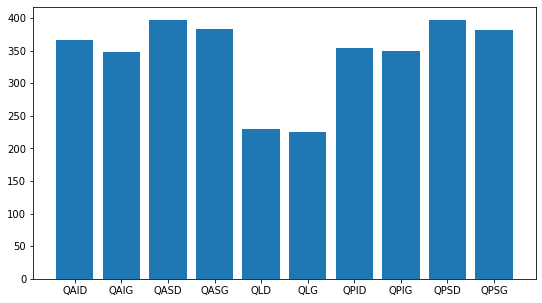

In [89]:
try:
    butterfly_site_nb.pop('UNK')
    butterfly_site_nb.pop('QASP')
except:
    print('It seems they were already removed')

plt.figure(figsize=(9,5))
plt.bar(butterfly_site_nb.keys(), butterfly_site_nb.values())

The data is more or less uniformly distributed, we have around 350-400 images per site. There are just the QLD and QLG sites that have around 220 images.

In [91]:
#Same problem here as before:
old_path = 'data/Ultrason butterflynetwork/1_195_QlG.mp4'
new_path = old_path.replace("QlG", "QLG", 1)
print(new_path)
#os.rename(old_path, new_path)

old_path2 = 'data/Ultrason butterflynetwork/1_184_QAiD_1.mp4'
new_path2 = old_path2.replace("QAiD", "QAID")
print(new_path2)
#os.rename(old_path2, new_path2)

data/Ultrason butterflynetwork/1_195_QLG.mp4
data/Ultrason butterflynetwork/1_184_QAID_1.mp4


In [92]:
butterfly_video_site_nb = dict(sorted(get_sites(vid_img_path).items()))
butterfly_video_site_nb

{'QAID': 129,
 'QAIG': 97,
 'QASD': 36,
 'QASG': 47,
 'QLD': 294,
 'QLG': 319,
 'QPAG': 2,
 'QPID': 156,
 'QPIG': 128,
 'QPSD': 34,
 'QPSG': 22,
 'UNK': 2}

<BarContainer object of 10 artists>

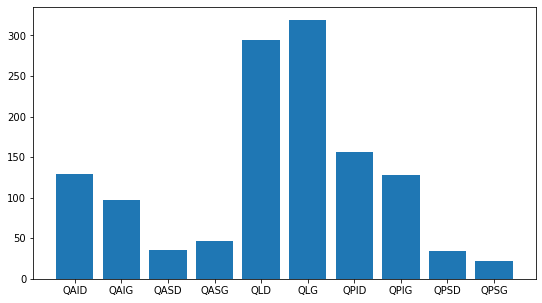

In [93]:
#Same thing here, we remove UNK videos and QPAG videos as their number is to low.
try:
    butterfly_video_site_nb.pop('UNK')
    butterfly_video_site_nb.pop('QPAG')
except:
    print('It seems they were already removed')

plt.figure(figsize=(9,5))
plt.bar(butterfly_video_site_nb.keys(), butterfly_video_site_nb.values())

Surprisingly, we have a lot more QLD and QLG videos. We know that experts didn't extract an image from every videos or could extract multiple from one. That's why we have this different between the images distribtution and the video distribution

In [48]:
lus_site_nb = get_sites(lus_neg_img_path)
lus_site_nb

{'QAID': 154,
 'QAIG': 113,
 'QASD': 158,
 'QASG': 153,
 'QLD': 89,
 'QLG': 83,
 'QPID': 113,
 'QPIG': 127,
 'QPSD': 129,
 'QPSG': 125,
 'QPG': 1}

<BarContainer object of 10 artists>

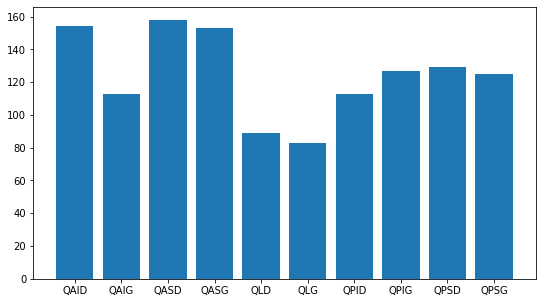

In [49]:
#Remove QPG image
try:
    lus_site_nb.pop('QPG')
except:
    print('It seems they were already removed')
    
plt.figure(figsize=(9,5))
plt.bar(lus_site_nb.keys(), lus_site_nb.values())

From the other dataset, the same kind of distribution can be observed on the images.

#### How many patients and videos per patient do we have?

In [124]:
def patients_videos(vid_path_list):
    """
    vid_path_list: list of paths of videos
    Returns: Dictionnary with patient number (name) and number of videos associated to him 
    """
    patients = {}
    for path in vid_path_list:
        splitted_path = path.split('_') #split the path
        patient = splitted_path[0][-1] + "_" + splitted_path[1] #extract the patient's number
        if patient not in patients.keys():
            patients[patient] = 1
        else:
            patients[patient] = patients[patient] + 1
    return patients

In [162]:
nb_patients_videos = patients_videos(vid_img_path)

In [126]:
print(f"We have {len(nb_patients_videos.keys())} patients")

We have 193 patients


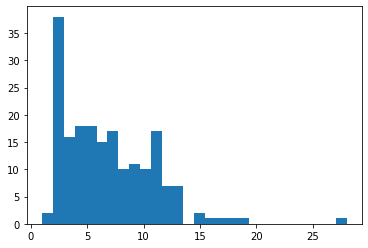

In [127]:
plt.hist(nb_patients_videos.values(), bins = max(nb_patients_videos.values()))
plt.show()

Seeing this, we want to know how many patients have actually videos from each site:

In [142]:
def sites_per_patient_videos(vid_path_list):
    """
    vid_path_list: list of paths of videos
    Returns: Dictionnary with patient number (name) and all sites that were performed on him
    """
    patients = {}
    for path in vid_path_list:
        splitted_path = path.split('_') #get the patient and the
        patient = splitted_path[0][-1] + "_" + splitted_path[1]
        
        site = splitted_path[2] #get the name of the video
        site = site.split(".")[0] #removes the extension
        
        if patient not in patients.keys():
            patients[patient] = set([site])
        else:
            patients[patient].add(site)
    return patients

In [145]:
sites_per_patient_dic = sites_per_patient_videos(vid_img_path)

In [149]:
nb_sites_per_patient = { k : len(v) for k,v in sites_per_patient_dic.items()}

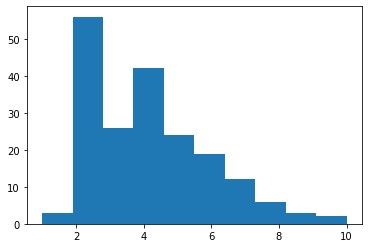

In [161]:
plt.hist(nb_sites_per_patient.values(), bins = max(nb_sites_per_patient.values()))
plt.show()

Almost every patient does not have one video per site.

## 2. Creating Datasets

In order to train our classifier, we require an image dataset with two different kind of labels:

* "True" images: selected by expert clinicians, these images are known to well represent a patient site and its useful features (such as pleural line, A-lines, B-lines ... etc).
* "False" images: taken from an LUS video, these images were not selected by an expert clinicians thus they do not represent the perfect shot for a given patient site (image can be blurry, features could be missing or angle shot can be weird and thus image is difficult to interpret).

Our initial data contains roughly a thousand expert selected images, which intuitively form our "True" labeled images. However, we do not have any image that would correspond to our "False" label. Therefore we have to generate them ourselves. We use the following methodology to accomplish our goal:

For a given "True" image, we iterate through images from its corresponding video. For each image, we compute a similarity value to the expert image and select the image as a False-labelled one based on this criteria. We require that the expert image and the selected image are not too similar to each other (since it would make the classification too hard), yet they should not be too different either (in order to better simulate the clinician options when selecting the best image). The details of the similarity metric are explained in later sections. 


### 2.1 Creating file folders

First of all, we need to create folders that will contain our data. These follow a specific architecture that enables us to use PyTorch Datasets and Dataloaders classes conveniently.

In [6]:
! mkdir data/butter_proc_images_similarity
! mkdir data/butter_proc_images_similarity/train
! mkdir data/butter_proc_images_similarity/val
! mkdir data/butter_proc_images_similarity/test
! mkdir data/butter_proc_images_similarity/test/test
! mkdir data/butter_proc_images_similarity/train/true
! mkdir data/butter_proc_images_similarity/train/false
! mkdir data/butter_proc_images_similarity/val/true
! mkdir data/butter_proc_images_similarity/val/false

### 2.2 Image preprocessing

We start by creating a mask that we will use to crop images, getting rid of features on the images (such as the scale, or name of site) that could otherwise perturb the training.
The mask has been crafted manually, as we did not have time to implement automatic edge detrection or similar mechanism to automate the process. We also define a couple functions for common preprocessing operations.

In [2]:
# Main mask used to capture the relevant portion of LUS images. Crafted manually. Is [1,1,1] where image is relevant

# Image dimensions
nb_rows = 1080
nb_cols = 792
nb_channels = 3

mask = np.zeros([nb_rows, nb_cols, nb_channels])

# Filling mask
for row in range(nb_rows):
    for col in range(nb_cols):
        # Delimitations of the cone like portion of a LUS image
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + nb_cols-293 > col:
            mask[row, col] = [1,1,1]

mask = mask.astype('uint8')
            
            
def resize_crop(image, mask, nb_cols=792, nb_rows=1080):
    """
    Resize image and apply mask
    """
    masked_img = cv2.resize(image, (nb_cols, nb_rows))*mask
    return masked_img


def read_crop(image_path, mask, nb_cols=792, nb_rows=1080):
    """
    Read image, resize to given dimensions and apply mask.
    
    Returns: image name, image
    """
    # Reading and masking image
    cv2_img = cv2.imread(image_path)
    masked_img = resize_crop(cv2_img, mask, nb_cols, nb_rows)

    # Selecting image name from path name
    img_name = os.path.split(image_path)[-1]
    
    return img_name, masked_img

### 2.3 Obtaining Test images

Before any dataset generation, we need to select and exclude a few images and video for our testing purposes. We selected five patient ids by hand. These patients present the advantage of having images and corresponding videos for most of the sites.

In [3]:
# patient ids used for the test set
test_ids = ['_151_','_136_', '_117_', '_45_', '_16_']

### 2.2 Obtaining Training and Validation images

We now proceed to dataset generation. First let us define our image similarity mechanism. 

#### 2.2.1 Similarity between two images

The similarity measure was inspired to us by ([Yang et al.](https://arxiv.org/abs/1706.04737), 2017). The idea is to encode a images to lesser dimensional format, reshape them as vector, and finally compute their cosine similarity. The encoding process is necessary to reduce complexity and also avoid potential harm caused by the curse of dimensionality (TODO Prove this). Encoding can be done in various ways. In our project, we selected two methods:
* Computing the mean brightness for a couple subparts of the image, in a convolutional fashion.
* Using a pretrained CNN model (resnet18) stripped from its last layers, as an encoder

The function ```create_brightness_matrix``` implements the first method TODO
Second method TODO

In [6]:
def create_brightness_matrix(img, mask=mask, side_length=200):
    """
    TODO
    """
    img = resize_crop(img, mask)
    # half_side determines the number of pixels per step of the "convolution"
    half_side = int(side_length / 2)
    nb_rows = img.shape[0] // half_side
    nb_cols = img.shape[1] // half_side
    matrix = np.zeros((nb_rows, nb_cols))
    
    for i in range(nb_rows) :
        for j in range(nb_cols) :
            matrix[i, j] = np.mean(img[half_side * i : half_side * i + side_length, half_side * j : half_side * j + side_length]) / 3
    
    return matrix

def cosine_similarity(vector1, vector2):
    """
    Compute the cosine similarity between two vectors of the same size
    """
    return np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))

# TODO not used as of now
def compute_similarity(img1, img2, encoder):
    """
    Compute similarity between two images based on cosine similarity.
    
    img_path1, img_path2: np.arrays
    encoder: function, retreives image and encodes as np.array
    return: int, cosine similarity
    """
    
    vec1 = encoder(img1).reshape(-1)
    vec2 = encoder(img2).reshape(-1)
    return cosine_similiraty(vec1, vec2)

Exploring cosine similarity with a few images (TODO should we keep this?) 

In [7]:
# Exploring some similarity values
im1 = cv2.imread('data/butter_proc_images_2/train/false/1_175_QLD_4.png')*mask
im2 = cv2.imread('data/butter_proc_images_2/train/true/1_135_QPSD.png')*mask
compute_similarity(im1, im2, create_brightness_matrix)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [8]:
im1 = cv2.imread('data/butter_proc_images_2/train/true/1_143_QPSD_1.png')*mask
im2 = cv2.imread('data/butter_proc_images_2/train/true/1_135_QPSD.png')*mask
compute_similarity(im1, im2, create_brightness_matrix)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

#### 2.2.1 Generating datasets

Armed with an encoder and a similarity measure, we can now tackle the image selection problem. We will proceed as described in Section 2.

The function ```generate_datasets``` iterates through images present in the given folder, namely the Ultrason butterflynetwork one. For each of these expert selected image, the function tries to find a corresponding (same patient, same site) video through the function ```find_video```. If such video is found, the ```extract_similar_image``` function then iterates through the video, computing the similarity measure between the video's frames and the expert image, in a sequential fashion. If a given frame satisfies the similarity criterias (not too different, not too similar), then both the expert image and the selected frames are saved in their respective folder, namely the True and False labelled ones.

Whenever a frame does not satisfy the similarity criterias, we do not compute similarity for the next couples frames because these are likely to give the same results considering there is very little change between two successive images in a video. This allows us to slightly reduce time complexity.

In [9]:
# TODO hyperparam search on these ?
MIN_SIMILARITY = 0.85
MAX_SIMILARITY = 0.95
LAST_SEEN_NB_FRAMES = 40

def generate_datasets(read_path, write_path, encoder=create_brightness_matrix, nb_samples=300 , train_ratio=0.8):
    """
    Creates samples for training and validation sets, using an image similarity criteria.
    """
    
    np.random.seed(1)
    images_path = read_path + '.png'
    images_path = np.random.permutation(glob.glob(images_path))
    images_path = [img for img in images_path if not any([(id_ in img) for id_ in test_ids])] # ignore images used for testing
    
    videos_path = read_path + '.mp4'
    videos_path = set(glob.glob(videos_path)) # transformed to set for faster queries
    
    nb_samples_train = int(nb_samples * train_ratio)
    sample_count = 0
        
    # Writing training and validation images to respective folders
    for image_path in images_path:
        # Finding corresponding video
        success, video_path = find_video(image_path, videos_path)
        if success == True:
            if sample_count >= nb_samples:
                break
            elif sample_count < nb_samples_train:
                count = extract_similar_image(image_path, video_path, f"{write_path}train/")
                sample_count += count
            else:
                count = extract_similar_image(image_path, video_path, f"{write_path}val/")
                sample_count += count
                
    if sample_count < nb_samples:
        print(f"Could not obtain enough samples: \nObtained : {sample_count} \nDemanded: {nb_samples}")

        
def extract_similar_image(image_path, video_path, write_path, mask=mask, encoder=create_brightness_matrix):
    """
    For a given image, extract a similar sample from the corresponding video (if it exists) and save it.
    """
    # Extracting and encoding the reference expert image
    exp_image = cv2.imread(image_path)
    exp_image_code = encoder(exp_image).reshape(-1)
    
    # Video exploitation
    video = cv2.VideoCapture(video_path)
    last_seen = LAST_SEEN_NB_FRAMES # variable to avoid considering two sample images that are almost the same 
    extraction_success = False
    
    while(video.isOpened()):
        success, sample_image = video.read()
        if (success == True):
            if (last_seen >= LAST_SEEN_NB_FRAMES) :
                # If we have access to an image, we encode it and verify the similarity to the expert image
                sample_image_code = encoder(sample_image).reshape(-1)
                similarity = cosine_similarity(exp_image_code, sample_image_code)

                # If the similarity criterion is satisfied, the image is selected
                if (similarity > MIN_SIMILARITY and similarity < MAX_SIMILARITY):
                    
                    # Saving sampled image
                    _, image_id = os.path.split(image_path)
                    cv2.imwrite(f"{write_path}false/{image_id}", resize_crop(sample_image, mask))
                    
                    # Saving corresponding expert image
                    cv2.imwrite(f"{write_path}true/{image_id}", resize_crop(exp_image, mask))
                    
                    extraction_success = True
                    video.release()
                else:
                    last_seen = 0
        else:
            #need to get out the while loop if we can't read a file
            video.release()
        last_seen += 1
    
    return extraction_success

        
def find_video(image_path, videos_path):
    """
    For a given unique image path, find if there is corresponding video in the given list of videos paths
    
    image_path: str, path of single image
    videos_path: set containing paths of all videos
    return: bool, str (operation success, video path)
    """
    video_path = image_path[:-4] + '.mp4'
    if(video_path in videos_path):
        return True, video_path
    else:
        return False, None

Generating the datasets.

In [27]:
generate_datasets(read_path='data/Ultrason butterflynetwork/*', write_path='data/butter_proc_images_similarity/', nb_samples=500)

## 3. Model testing

With our data correctly labeled and organised, we can now proceed to training our model. Training is done in the ```classifier.ipynb``` notebook. In this notebook we directly load our trained models and test them.

### 3.1 Loading the model

In [17]:
load_path = "models/similarity/bright_matrix/09_12_resnet18_natural_500_85_95"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading model architecture
model_test = models.resnet18(pretrained=True)
num_ftrs = model_test.fc.in_features
model_test.fc = nn.Linear(num_ftrs, 2)

# Loading parameters to the model
model_test.load_state_dict(torch.load(load_path))
model_test = model_test.to(device)
model_test.eval()

# Images transformations to apply before entering model
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                #transforms.RandomHorizontalFlip
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456(),, 0.406], [0.229, 0.224, 0.225])])

### 3.2 Testing

In order to test our model's extraction power we once again use the notion of similarity. For our selected test images, we iterate through the corresponding video running each frame into our model. The one frame that achieves highest confidence as a "True" image is to be selected. We then compute the similarity between our selected image and the expert one. This measure is our testing metric. The higher, the closer our model as been able to emulate the expert's decision. 

In [18]:
def prepare_for_model(img, transform=transform):
    """
    Read image and apply required transformations for model usage
    """
    # Read, resize and crop
    img = resize_crop(img, mask)
    # Transform to PIL format
    img = Image.fromarray(img)
    # Model transformations
    return transform(img)


def test_model(model, test_folder_path, encoder):
    """
    Test the given model on images and videos contained in the given folder, based on a similarity metric
    Return the average similarity between expert images and model selectd images from the corresponding videos
    """
    images_path = test_folder_path + 'test/*.png'
    images_path = glob.glob(images_path)
    
    videos_path = test_folder_path + 'test/*.mp4'
    videos_path = set(glob.glob(videos_path)) # transformed to set for faster queries
    
    similarities = []
    
    # Use model on image every 'skip' frames
    skip = 10
    # TODO debug stuff
    #images_path = images_path[:3]
    #print(images_path)
    
    for image_path in images_path:
        # Finding corresponding video
        success, video_path = find_video(image_path, videos_path)
        if(success == True):
            # Scanning the video
            video = cv2.VideoCapture(video_path)
            frame = 0
            best_confidence = 0
            selected_image = None
            while(video.isOpened()):
                success, sample_image = video.read()
                if(success == True):
                    frame += 1
                    if(frame % skip == 0):
                        # Sampled image goes through the model
                        model_image = prepare_for_model(sample_image)
                        model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
                        model_image = model_image.to(device)
                        probabilities = nn.functional.softmax(model(model_image), dim = 1)
                        confidence = probabilities[0,1]

                        if(confidence >= best_confidence):
                            best_confidence = confidence
                            selected_image = sample_image.copy()
                else:
                    video.release()
            
            # Computing similarity
            if selected_image is not None:
                exp_image = cv2.imread(image_path)
                exp_image_code = encoder(exp_image).reshape(-1)
                selected_image_code = encoder(selected_image).reshape(-1)
                similarity = cosine_similarity(exp_image_code, selected_image_code)
                similarities.append(similarity)
    
    # Averaging similarity TODO think of another method ?
    return np.mean(similarities)

Computing average similarity over the test set:

In [19]:
test_folder_path = "data/butter_proc_images_similarity/test/"
test_model(model_test, test_folder_path, create_brightness_matrix)

0.9506286917158284

In [20]:
# TODO why is it different for two runs on the same set ?
test_folder_path = "data/butter_proc_images_similarity/test/"
test_model(model_test, test_folder_path, create_brightness_matrix)

0.9506286917158284

In [16]:
test_folder_path = "data/butter_proc_images_similarity/test/"
test_model(model_test, test_folder_path, create_brightness_matrix)

0.9451249742779325

In [4]:
encoder = CnnEncoder()